# Convolutional Neural Network for Image Classification

This notebook contains a Convolutional Neural Network (CNN) implemented in Keras for classifying images. The CNN is trained on a dataset of chest X-ray images, with the aim of detecting whether or not the images contain signs of pneumonia.

The notebook is structured as follows:

- **Importing Libraries**: Necessary libraries and modules are imported.
- **Data Preparation**: The image data is loaded and preprocessed for training.
- **Model Building**: The CNN model is defined and compiled.
- **Model Training**: The model is trained on the training data and validated on the validation data.
- **Model Evaluation**: The model's performance is evaluated on the test data.
- **Model Saving**: The trained model is saved for future use.

Let's get started!

## Importing Libraries

First, we import all the necessary libraries and modules for our CNN. This includes TensorFlow and Keras for building the CNN, as well as os and numpy for data handling.

In [1]:
import os
import itertools
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import Sequence
from keras.utils import to_categorical
from keras.models import Sequential
from keras import metrics
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, SeparableConv2D,BatchNormalization, LeakyReLU, GlobalAveragePooling2D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

import datetime
import tensorflow as tf

In [2]:
%load_ext tensorboard

In [3]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


## Data Preparation

Next, we set up the paths to the directories containing our training, validation, and test data. We also define some parameters for our images and training process, such as the image dimensions, the batch size, and the number of epochs.

In [4]:
# Set up data directories
normal_data_dir = "chest_Xray\\train\\NORMAL"
pneumonia_data_dir = "chest_Xray\\train\\PNEUMONIA"
train_data_dir = "chest_Xray\\train"
validation_data_dir = "chest_Xray\\val"
test_data_dir = "chest_Xray\\test"

# Define image parameters
img_height = 256
img_width = 256
num_channels = 3  # Set to 1 for grayscale images

# Define training parameters
batch_size = 16
num_epochs = 30
learning_rate = 0.01
es_patience = 3
reducelrp_factor = 0.5

We then set up our image data generators. These will automatically load our images from the directories, apply some data augmentation techniques to the training images to increase the diversity of our training data, and rescale the pixel values from [0, 255] to [0, 1].

## Model Building

Next, we define our CNN model. This is a sequential model with several convolutional layers, each followed by a max pooling layer. We also include dropout layers to reduce overfitting, and a final dense layer for binary classification.

In [5]:
# Define the model
model = Sequential([
    Conv2D(8, (3, 3), activation=LeakyReLU(), input_shape=(img_height, img_width, num_channels), padding='same'),
    BatchNormalization(),
    Conv2D(16, (3, 3), activation=LeakyReLU(), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(32, (3, 3), activation=LeakyReLU(), padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation=LeakyReLU(), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation=LeakyReLU(), padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation=LeakyReLU(), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    GlobalAveragePooling2D(),
    Dense(256, activation='elu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(256, activation='elu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='elu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(64, activation='elu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


After defining the model, we compile it with the Adam optimizer and binary crossentropy loss function, since this is a binary classification problem. We also specify that we want to track accuracy as a metric during training.

In [6]:
# Compile the model
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=[
        'accuracy', 
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='auc')
    ]
)

TensorBoard logs

In [7]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

We also set up some callbacks for our training process. The `EarlyStopping` callback will stop the training if the validation loss does not improve for a certain number of epochs, and the `ReduceLROnPlateau` callback will reduce the learning rate when the validation loss stops improving, to allow for finer tuning.

In [8]:
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=es_patience, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=reducelrp_factor, patience=3, verbose=1, min_lr=1e-6)

## Model Training

Now we're ready to train our model. We first set up our data generators to load the images, and then we call the `fit` method on our model to start the training.

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)
# No rotation as X-Rays are not usually rotated
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
class_weight = {0: 1.4, 1: 1.}

num_normal = len(os.listdir(normal_data_dir))
num_pneumonia = len(os.listdir(pneumonia_data_dir))

class_weight = {0: num_pneumonia / num_normal, 1: 1.}

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=num_epochs,
    class_weight=class_weight,  # Add this line
    callbacks=[reduce_lr_on_plateau, tensorboard_callback, tboard_callback]  # Add the EarlyStopping callback here
)

Epoch 1/30
326/326 [==============================] - 99s 284ms/step - loss: 1.2087 - accuracy: 0.8215 - val_loss: 2.0285 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
326/326 [==============================] - 98s 300ms/step - loss: 0.9777 - accuracy: 0.8393 - val_loss: 2.2181 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
326/326 [==============================] - 98s 299ms/step - loss: 0.8185 - accuracy: 0.8441 - val_loss: 1.3986 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/30
326/326 [==============================] - 96s 292ms/step - loss: 0.6938 - accuracy: 0.8551 - val_loss: 1.3846 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/30
326/326 [==============================] - 97s 297ms/step - loss: 0.6153 - accuracy: 0.8572 - val_loss: 1.6619 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/30
326/326 [==============================] - 96s 295ms/step - loss: 0.5373 - accuracy: 0.8723 - val_loss: 1.9008 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/30
326/326 [==============================] 

In [ ]:
%tensorboard --logdir logs/fit


## Model Evaluation

After training, we evaluate our model on the test data to see how well it performs.

In [12]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

39/39 [==============================] - 4s 106ms/step - loss: 0.4857 - accuracy: 0.8317
Test loss: 0.4857, Test accuracy: 0.8317


## Model Saving

Finally, we save our trained model for future use. In a real-world scenario, you would likely want to use this model to make predictions on new data.

In [13]:
# Save the model
model.save("chest_xray_model.h5")
print("Model saved as chest_xray_model.h5")

Model saved as chest_xray_model.h5


INFERENCE

In [14]:

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image


In [18]:
normal_folder = "chest_Xray\\test\\NORMAL"
pneumonia_folder = "chest_Xray\\test\\PNEUMONIA"
models_folder = r"models"
img_height = 256
img_width = 256

model_results = []

In [19]:
def preprocess_image(image_path, img_height, img_width):
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # expand dimensions for batch input
    return img_array

for model_name in os.listdir(models_folder):
        model_path = os.path.join(models_folder, model_name)
        if not os.path.isfile(model_path):
            continue

        loaded_model = load_model(model_path)

        def is_prediction_correct(image_path, true_class):
            preprocessed_image = preprocess_image(image_path, img_height, img_width)
            prediction = loaded_model.predict(preprocessed_image)
            predicted_class = "pneumonia" if prediction[0][0] > 0.5 else "normal"
            return predicted_class == true_class

        results = {
            "normal": {"correct": 0, "total": 0},
            "pneumonia": {"correct": 0, "total": 0},
        }

        for folder, true_class in [(normal_folder, "normal"), (pneumonia_folder, "pneumonia")]:
            for image_name in os.listdir(folder):
                image_path = os.path.join(folder, image_name)
                results[true_class]["total"] += 1
                if is_prediction_correct(image_path, true_class):
                    results[true_class]["correct"] += 1

        total_correct = results["normal"]["correct"] + results["pneumonia"]["correct"]
        total_images = results["normal"]["total"] + results["pneumonia"]["total"]
        normal_correct_pct = (results["normal"]["correct"] / results["normal"]["total"]) * 100
        pneumonia_correct_pct = (results["pneumonia"]["correct"] / results["pneumonia"]["total"]) * 100
        overall_correct_pct = (total_correct / total_images) * 100

        model_results.append({
            "name": model_name,
            "results": results,
            "total_correct": total_correct,
            "normal_correct_pct": normal_correct_pct,
            "pneumonia_correct_pct": pneumonia_correct_pct,
            "overall_correct_pct": overall_correct_pct
        })

1/1 [==============================] - 0s 20ms/step


In [20]:
sorted_by_total_correct = sorted(model_results, key=lambda x: x["total_correct"], reverse=True)
sorted_by_normal_correct_pct = sorted(model_results, key=lambda x: x["normal_correct_pct"], reverse=True)
sorted_by_pneumonia_correct_pct = sorted(model_results, key=lambda x: x["pneumonia_correct_pct"], reverse=True)

print("Sorted by total correct:")
for result in sorted_by_total_correct:
    print(result["name"], result["total_correct"], result["overall_correct_pct"])

print("\nSorted by normal correct %:")
for result in sorted_by_normal_correct_pct:
    print(result["name"], result["normal_correct_pct"])

print("\nSorted by pneumonia correct %:")
for result in sorted_by_pneumonia_correct_pct:
    print(result["name"], result["pneumonia_correct_pct"])
    

Sorted by total correct:
chest_xray_model.h5 519 83.17307692307693

Sorted by normal correct %:
chest_xray_model.h5 61.53846153846154

Sorted by pneumonia correct %:
chest_xray_model.h5 96.15384615384616


ROC CURVE

39/39 [==============================] - 5s 114ms/step


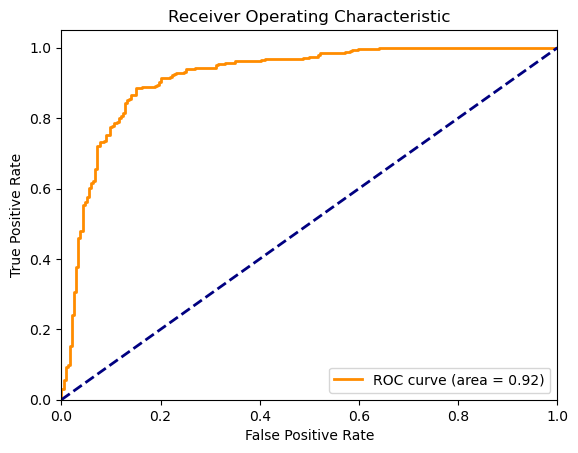

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'test_generator' contains the test data
y_test = test_generator.classes
# predict probabilities for test set
y_pred = model.predict(test_generator, verbose=1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
